# Tutorial: Organellar Immunoprecipitation (OrgIP) Workflow 

*grassp* is a Python package that facilitates the analysis of subcellular proteomics data (with an emphasis on graph-based analyses).  
In this tutorial, we analyze subcellular proteomics data produced by Organellar Immunoprecipitation (OrgIP). 


In [73]:
import grassp as gr
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas
import numpy as np

# Larger dpi to make plots larger
plt.rcParams["figure.dpi"] = 150

## Reading files

We'll load the count matrix into an AnnData object, a data structure that provides multiple compartments for storing annotations and various data representations.  
For a comprehensive AnnData tutorial, refer to the [Getting Started with AnnData](https://anndata.readthedocs.io/en/stable/tutorials/notebooks/getting-started.html) guide.


In [74]:
# adata = sc.read_h5ad("hein2024_raw.h5ad")
adata = gr.datasets.hein_2024(enrichment="raw", include_whole_proteome=True)


The organelle IP data in this tutorial comes from Hein et al. (*Cell*, 2025) from the Leonetti and Elias labs at CZ Biohub SF.  

To produce this dataset, HEK293T cells were CRISPR-tagged with epitope-labeled organelle marker proteins, gently homogenized, and intact organelles are rapidly immunocaptured on antibody-coated magnetic beads for label-free LC–MS; a simple benchtop spin in parallel generates nuclear (N, 1,000 × g pellet), membrane-bound organellar (O, 20,000 × g pellet), and cytosolic (C, supernatant) N/O/C fractions.  

Unlike centrifugation-based correlation profiling—where compartments are inferred from how proteins distribute across many fractions, organelle immunocapture enriches one compartment at a time via affinity capture of a tagged marker, enabling high-subcellular resolution at the proteome scale and analysis of organelle interconnections..

In [75]:
## print information about the loaded dataset
adata

AnnData object with n_obs × n_vars = 14551 × 225
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical'
    var: 'Sample', 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'biological_replicate', 'covariate_Bait', 'covariate_Batch'
    uns: 'RawInfo'
    layers: 'Intensity', 'MS_MS count'

## Preprocessing

### Adding Compartment Annotations
We add ground-truth subcellular compartment annotations.

In [76]:
gr.pp.add_markers(
    adata,
    species="hsap",
)
adata.obs.head()

Added lilley annotations for 338/14551 proteins (2.3%)
Added christopher annotations for 809/14551 proteins (5.6%)
Added geladaki annotations for 268/14551 proteins (1.8%)
Added itzhak annotations for 578/14551 proteins (4.0%)
Added villaneuva annotations for 357/14551 proteins (2.5%)
Added hein2024_component annotations for 4272/14551 proteins (29.4%)
Added hein2024_gt_component annotations for 1223/14551 proteins (8.4%)


,Protein IDs,Majority protein IDs,Protein names,Gene names,Fasta headers,Number of proteins,Unique + razor sequence coverage [%],Unique sequence coverage [%],Mol. weight [kDa],Sequence length,...,Reverse,Potential contaminant,Gene_name_canonical,lilley,christopher,geladaki,itzhak,villaneuva,hein2024_component,hein2024_gt_component
index,,,,,,,,,,,,,,,,,,,,,
A0A023Q8X7,A0A023Q8X7;H9PV83;A3FP67;D0UTS7;G3LZE0;Q0ZF73;...,A0A023Q8X7;H9PV83;A3FP67;D0UTS7;G3LZE0;Q0ZF73;...,NADH-ubiquinone oxidoreductase chain 5,ND5,tr|A0A023Q8X7|A0A023Q8X7_HUMAN NADH-ubiquinone...,80,1.5,1.5,67.029,603,...,NaN,NaN,MT-ND5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A023QZ25,A0A023QZ25;A0A6H0MWV7;A0A059QLX8;H9RAX1;A0A7D5...,A0A023QZ25;A0A6H0MWV7;A0A059QLX8;H9RAX1;A0A7D5...,Cytochrome c oxidase subunit 2,COX2;COII;cox2,tr|A0A023QZ25|A0A023QZ25_HUMAN Cytochrome c ox...,112,12.8,12.8,25.597,227,...,NaN,NaN,MT-CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A023T6R1,A0A023T6R1;Q96A72;F5H6P7;F5H6N1;F5H3U9;F5H124,A0A023T6R1;Q96A72;F5H6P7;F5H6N1,Protein mago nashi homolog 2,FLJ10292;MAGOHB,tr|A0A023T6R1|A0A023T6R1_HUMAN Mago nashi prot...,6,6.1,6.1,17.276,148,...,NaN,NaN,MAGOHB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y5S9,Q9Y5S9;A0A023T787;A0A0J9YW13,Q9Y5S9;A0A023T787,RNA-binding protein 8A,RBM8A;RBM8,sp|Q9Y5S9|RBM8A_HUMAN RNA-binding protein 8A O...,3,78.7,78.7,19.889,174,...,NaN,NaN,RBM8A,NaN,NaN,NaN,NaN,NaN,Nucleus,NaN
A0A024DAK3,A0A024DAK3;A2IBT2;A2IBT1,A0A024DAK3,NaN,NaN,tr|A0A024DAK3|A0A024DAK3_HUMAN RNA-specific ad...,3,1.3,1.3,136.000,1226,...,NaN,NaN,A0A024DAK3[p],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
adata.var.subcellular_enrichment.unique()

['CAPRIN1', 'UNTAGGED', 'ATG101', 'COPE', 'DCP1A', ..., 'SLC30A2', 'CYTOSOL', 'NUCLEAR', 'ORGANELLE', 'PROTEOME']
Length: 43
Categories (43, object): ['ACTB', 'ATG101', 'ATP1B3', 'CAPRIN1', ..., 'UNTAGGED', 'VPS35', 'YWHAB', 'YWHAQ']

### Filtering

In [78]:
adata_filtered = adata.copy()

`grassp.pp` provides filtering functions to remove low-quality proteins (pp stands for preprocessing).  
Here, we filter out proteins annotated as contaminants by MaxQuant and remove proteins that were not detected in at least two IPs across all three replicates

In [79]:
# Remove known contaminants and Decoy proteins from the proteins (based on the MaxQuant output)
print(f"Before n_proteins x n_samples: {adata.shape}")
gr.pp.remove_contaminants(
    adata_filtered,
    filter_columns=["Only identified by site", "Reverse", "Potential contaminant"],
    filter_value="+",
)
print(f"After n_proteins x n_samples:: {adata_filtered.shape}")

Before n_proteins x n_samples: (14551, 225)
After n_proteins x n_samples:: (10852, 225)


In [80]:
# Use paired whole proteome data to filter proteins that are low abundance in the cell
print(f"Before n_proteins x n_samples: {adata_filtered.shape}")
adata_proteome = adata_filtered[:, adata_filtered.var.subcellular_enrichment == "PROTEOME"]
protein_mask, n_per_protein = gr.pp.filter_proteins(
    adata_proteome, min_samples=2, inplace=False
)
adata_filtered = adata_filtered[protein_mask, :]
print(f"After n_proteins x n_samples:: {adata_filtered.shape}")

Before n_proteins x n_samples: (10852, 225)
After n_proteins x n_samples:: (8641, 225)


In [81]:
print(f"Before n_proteins x n_samples: {adata_filtered.shape}")
gr.pp.filter_proteins_per_replicate(
    adata_filtered,
    grouping_columns=["covariate_Bait"],
    min_replicates=3,
    inplace=True,
)
print(f"After n_proteins x n_samples:: {adata_filtered.shape}")

Before n_proteins x n_samples: (8641, 225)
After n_proteins x n_samples:: (8599, 225)


### Transformation and imputation

#### Normalization (log1p transformation)
Methods like PCA work best when features are on comparable scales and extreme skewness/outliers are reduced. Because protein count/abundance data are typically right-skewed with variance that increases with the mean, we apply a log1p transformation (log(1 + x)) to compress the dynamic range, reduce skewness, and stabilize variance before PCA and downstream visualization.

In [ ]:
# Anndata has a useful layers feature that allows us to keep different transformed versions of the data.
# We can use the "LFQ" layer to store the untransformed lfq values
adata_filtered.layers["LFQ"] = adata_filtered.X.copy()

sc.pp.log1p(adata_filtered)
# The log transformed data is stored in the "X" layer, and the untransformed data is stored in the "LFQ" layer
adata_filtered

AnnData object with n_obs × n_vars = 8599 × 225
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component'
    var: 'Sample', 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'biological_replicate', 'covariate_Bait', 'covariate_Batch'
    uns: 'RawInfo', 'lilley_colors', 'christopher_colors', 'geladaki_colors', 'itzhak_colors', 'villaneuva_colors', 'hein2024_component_colors', 'hein2024_gt_component_colors', 'log1p'
    layers: 'Intensity', 'MS_MS count', 'LFQ'

#### Imputing
Mass spectrometry data often contain missing values because proteins with low abundance can fall below the instrument’s detection/identification threshold and therefore go  unquantified in some runs.

Imputation mitigates this technical missingness by replacing absent entries with plausible values, enabling downstream analyses that require complete matrices (e.g., PCA, clustering, differential testing). In this workflow, grassp uses a left-shifted Gaussian approach (i.e., sampling small values from a distribution shifted toward low intensities) to reflect values likely below the detection limit, though alternative imputation methods can be selected depending on the dataset and assumptions.

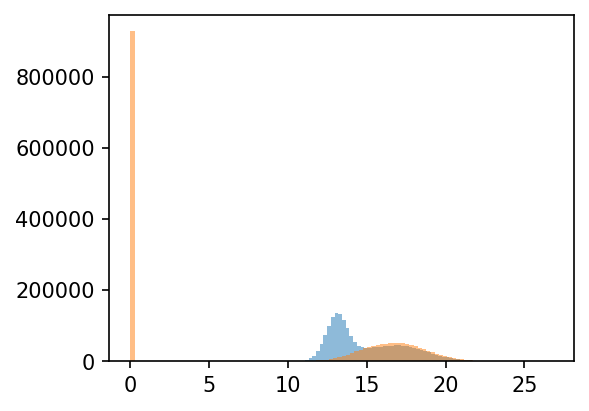

In [83]:
# Impute the missing values with a gaussian distribution at the lower tail of the intensity distribution
plt.figure(figsize=(4, 3))
adata_filtered.layers["log_unimputed"] = adata_filtered.X.copy()
gr.pp.impute_gaussian(adata_filtered)
_ = plt.hist(adata_filtered.X.flatten(), bins=100, alpha=0.5)
_ = plt.hist(adata_filtered.layers["log_unimputed"].flatten(), bins=100, alpha=0.5)

## Calculate enrichment

Split up dataset into IP fractions and NOC since enrichment is computed separately for each.

In [84]:
# Enrichment of the IP fractions is calculated against the untagged samples in the same batch
adata_ip = adata_filtered[:, ~adata_filtered.var.covariate_Experiment.isin(["NOC", "PROTEOME"])].copy()
adata_ip_enr = gr.pp.calculate_enrichment_vs_untagged(
    adata_ip,
    covariates="covariate_Batch",
    subcellular_enrichment_column="covariate_Bait",
    untagged_name=".._UNTAGGED",
)

# adata_ip = adata_ip[:, adata_ip.var.subcellular_enrichment != "UNTAGGED"]
# adata_ip_enr = gr.pp.calculate_enrichment_vs_all(
#     adata_ip,
#     covariates="covariate_Batch",
#     subcellular_enrichment_column="covariate_Bait",
# )
adata_ip_enr


AnnData object with n_obs × n_vars = 8599 × 58
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_imputed'
    var: 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'covariate_Bait', 'covariate_Batch', 'n_merged_samples'
    uns: 'RawInfo', 'lilley_colors', 'christopher_colors', 'geladaki_colors', 'itzhak_colors', 'villaneuva_colors', 'hein2024_component_colors', 'hein2024_gt_component_colors', 'log1p'
    layers: 'Intensity', 'MS_MS count', 'LFQ', 'log_unimputed', 'pvals'

In [85]:
# Enrichment of the NOC samples is calculated as a logFC
adata_noc = adata_filtered[:, adata_filtered.var.covariate_Experiment == "NOC"].copy()

# First average the Replicates
adata_noc_enr = gr.pp.aggregate_samples(
    adata_noc, grouping_columns=["subcellular_enrichment"], agg_func=np.mean
)

adata_noc_enr.X = adata_noc_enr.X - adata_noc_enr.X.mean(axis=1)[:, None]

adata_noc_enr


AnnData object with n_obs × n_vars = 8599 × 3
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_imputed'
    var: 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'covariate_Bait', 'n_merged_samples'
    uns: 'RawInfo', 'lilley_colors', 'christopher_colors', 'geladaki_colors', 'itzhak_colors', 'villaneuva_colors', 'hein2024_component_colors', 'hein2024_gt_component_colors', 'log1p'
    layers: 'Intensity', 'MS_MS count', 'LFQ', 'log_unimputed'

In [86]:
# Finally recombine the enrichment data with the NOC data
adata_enr = ad.concat(
    [adata_ip_enr, adata_noc_enr], axis=1, merge="first", uns_merge="first"
)
adata_enr


/var/folders/sq/2c1gpqnj1956z6__rj_d69gh0000gp/T/ipykernel_85525/3312497296.py:2: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  adata_enr = ad.concat(


AnnData object with n_obs × n_vars = 8599 × 61
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_imputed'
    var: 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'covariate_Bait', 'n_merged_samples'
    uns: 'RawInfo', 'lilley_colors', 'christopher_colors', 'geladaki_colors', 'itzhak_colors', 'villaneuva_colors', 'hein2024_component_colors', 'hein2024_gt_component_colors', 'log1p'
    layers: 'Intensity', 'MS_MS count', 'LFQ', 'log_unimputed'

## Dimensionality Reduction

### PCA plots 
After filtering, transformation, and computing enrichment, we can move on to visualization and interpretation!  
The following plots show how proteins cluster in reduced dimensional space based on their intensity patterns across IPs and NOC fractions, revealing groups of co-localized proteins and identifying potential subcellular localization signatures.

In [87]:
sc.pp.scale(adata_enr)

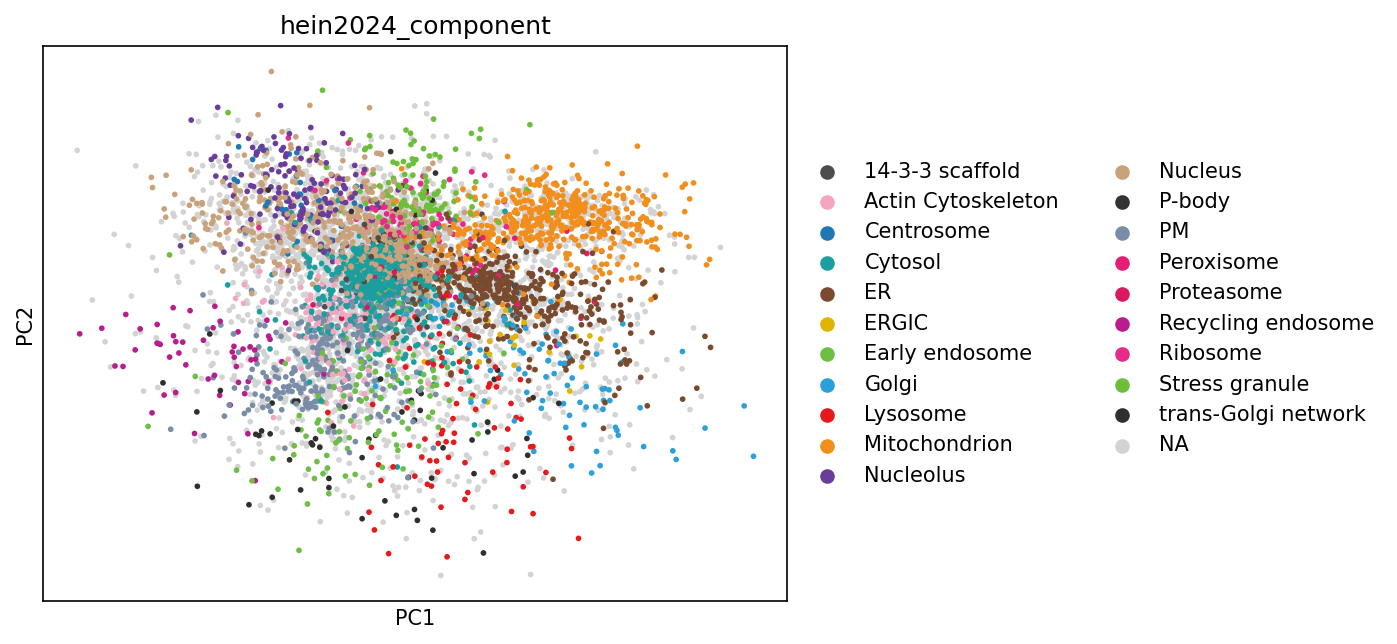

In [88]:
# We can use PCA to visualize
sc.pp.pca(adata_enr)
sc.pl.pca(adata_enr, color=["hein2024_component"], size=30)
# Note that the resolution does not look great. This is because on the OrgIP data 2PCs are not enough to resolve the variation in the dataset.

### UMAPs
While PCA provides a linear dimensionality reduction, UMAP offers a non-linear approach that can better preserve local neighborhood structures and reveal more complex patterns in protein localization data that might be missed by linear methods.

In [89]:
sc.pp.neighbors(adata_enr, n_neighbors=10, use_rep="X")
sc.tl.umap(adata_enr, min_dist=0.1)

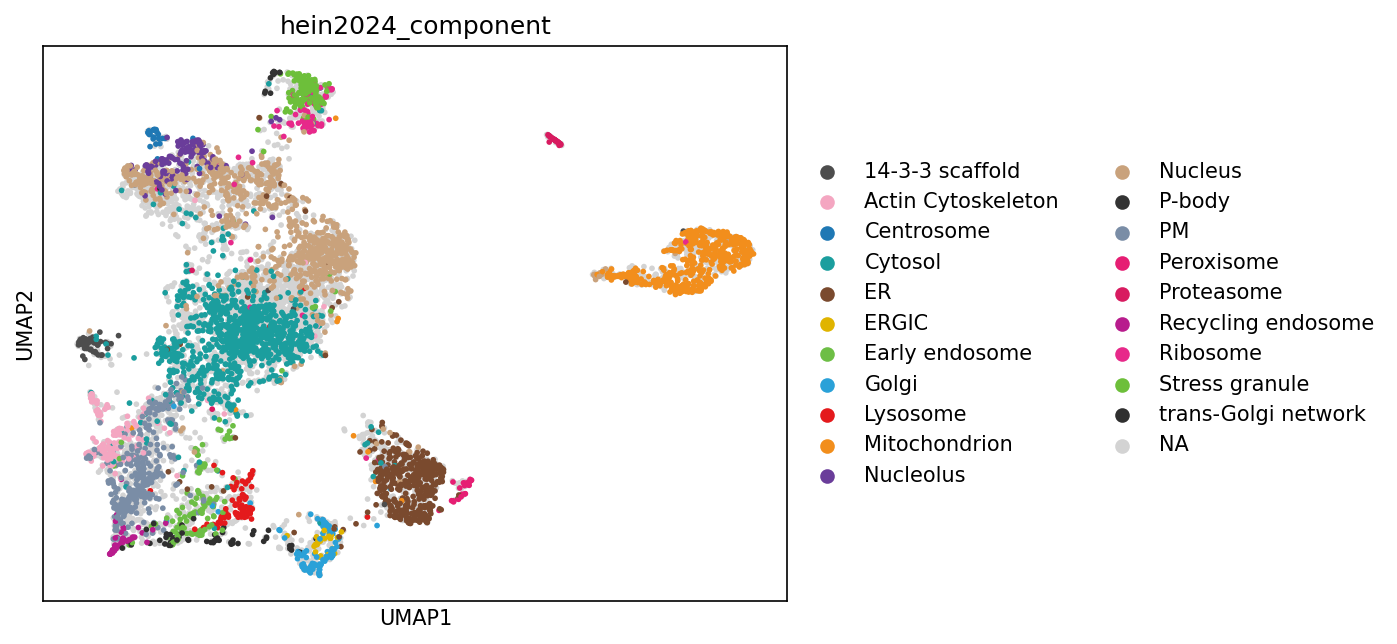

In [90]:
# This simplified workflow reproduces most clusters of the original publication well. Slight differences are expected due to different preprocessing steps.
sc.pl.umap(adata_enr, color=["hein2024_component"], size=30)

## Compartment Annotation

A central goal of subcellular proteomics is to infer the cellular compartment (localization) of each observed protein. One common strategy is to start from a set of marker proteins with known localization and then transfer those labels to proteins with similar subcellular profiles.

In grassp, the `knn_annotation` function implements this approach by propagating compartment labels from marker proteins to nearby proteins in the protein–protein neighbor graph

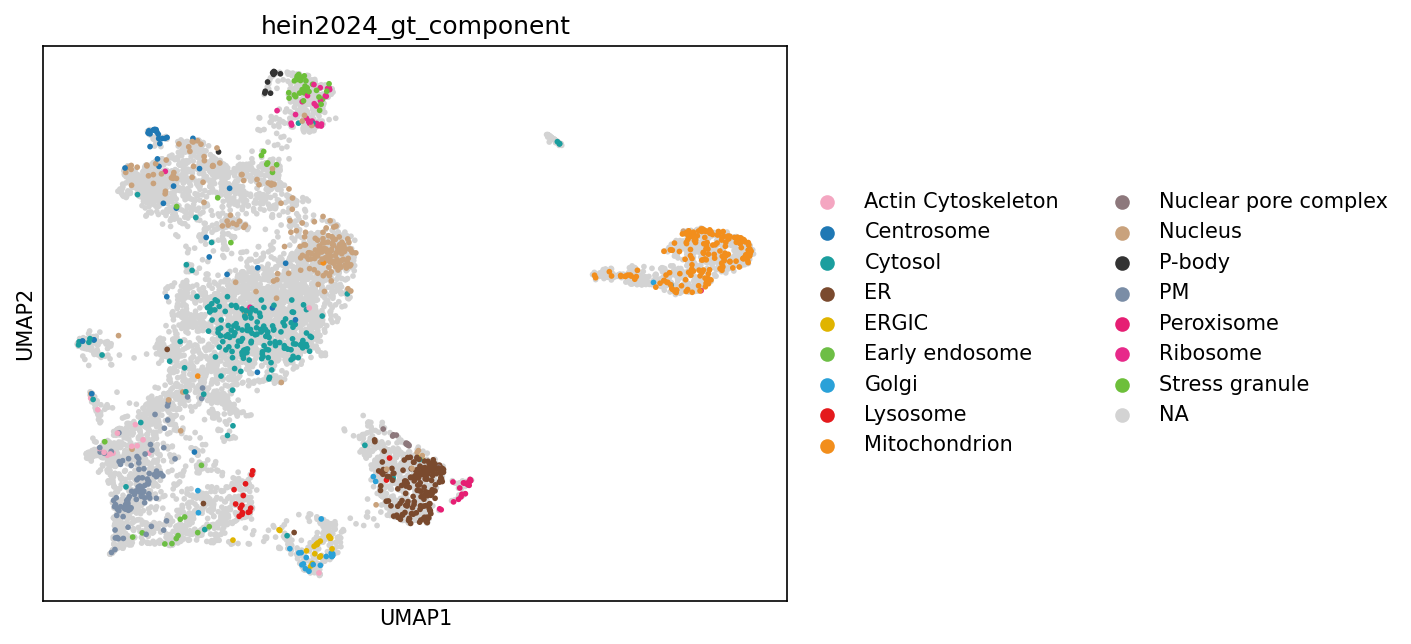

In [91]:
# We will use the ground truth created for the original publication.

sc.pl.umap(adata_enr, color=["hein2024_gt_component"], size=30)

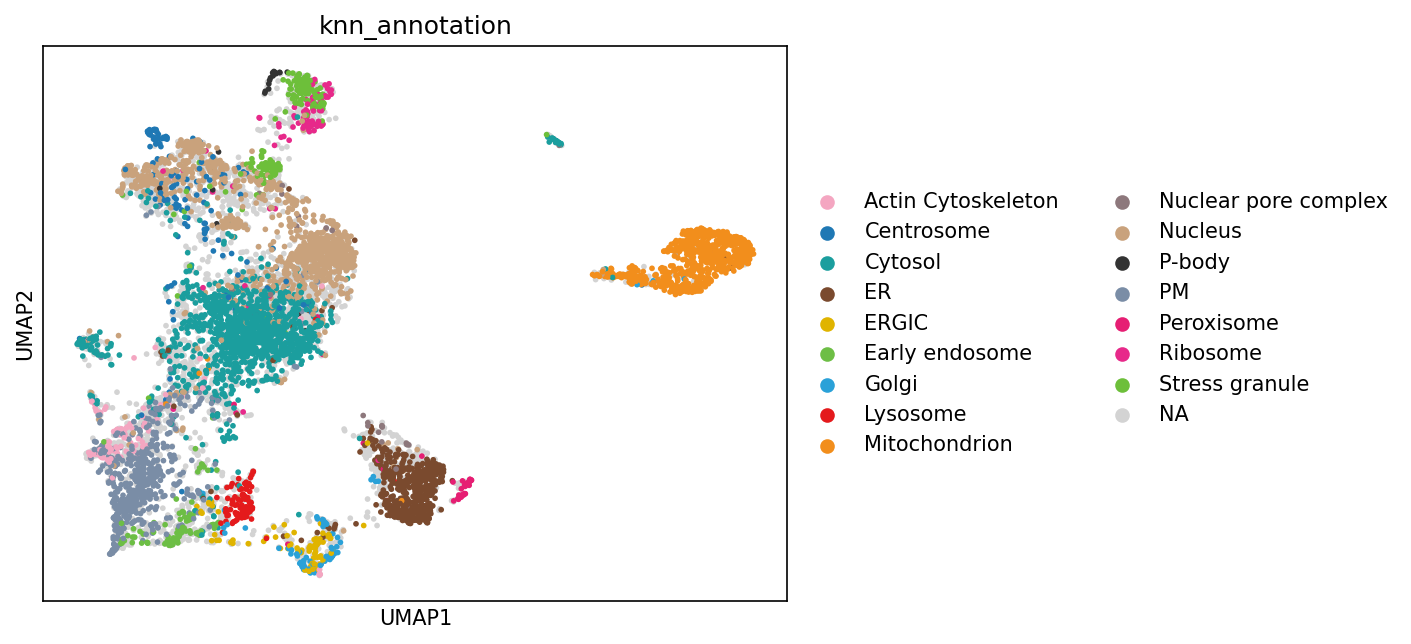

In [92]:
gr.tl.knn_annotation(
    adata_enr,
    gt_col="hein2024_gt_component",
    key_added="knn_annotation",
    min_probability=0.9,
)
sc.pl.umap(adata_enr, color=["knn_annotation"], size=30)

After these steps, you will see that new analysis results are stored in various Anndata compartments: PCA components and UMAP coordinates are saved in .obsm, while metadata like search engine parameters and visualization settings are stored in .uns, and protein-protein relationships are captured in .obsp as distance and connectivity matrices. 

>   uns: 'log1p', 'pca', 'hein2024_gt_component_colors', 'hein2024_component_colors', 'neighbors', 'umap', 'knn_annotation_colors'

>   obsm: 'X_pca', 'X_umap'

>   obsp: 'distances', 'connectivities'

In [93]:
# print the resulting Anndata object
adata_enr

AnnData object with n_obs × n_vars = 8599 × 61
    obs: 'Protein IDs', 'Majority protein IDs', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'Gene_name_canonical', 'lilley', 'christopher', 'geladaki', 'itzhak', 'villaneuva', 'hein2024_component', 'hein2024_gt_component', 'n_imputed', 'knn_annotation', 'knn_annotation_probability'
    var: 'covariate_Experiment', 'subcellular_enrichment', 'covariate_Condition', 'covariate_Bait', 'n_merged_samples', 'mean', 'std'
    uns: 'RawInfo', 'lilley_colors', 'christopher_colors', 'geladaki_colors', 'itzhak_colors', 'villaneuva_colors', 'hein2024_component_colors', 'hein2024_gt_component_colors', 'log1p', 'pca', 'neighbors', 'umap', 'knn_annotation_colors'
    obsm: 'X_pca', 'X_umap', 'knn_annotation_probabilitie

## Optional: Unsupervised Annotation

Alternatively we can use unsupervised clustering to create annotations. This approach does not depend on a predefined set of marker or ground-truth proteins; instead, it relies on an appropriate clustering method and a public pathway database for interpretation.

/var/folders/sq/2c1gpqnj1956z6__rj_d69gh0000gp/T/ipykernel_85525/444867665.py:2: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata_enr)


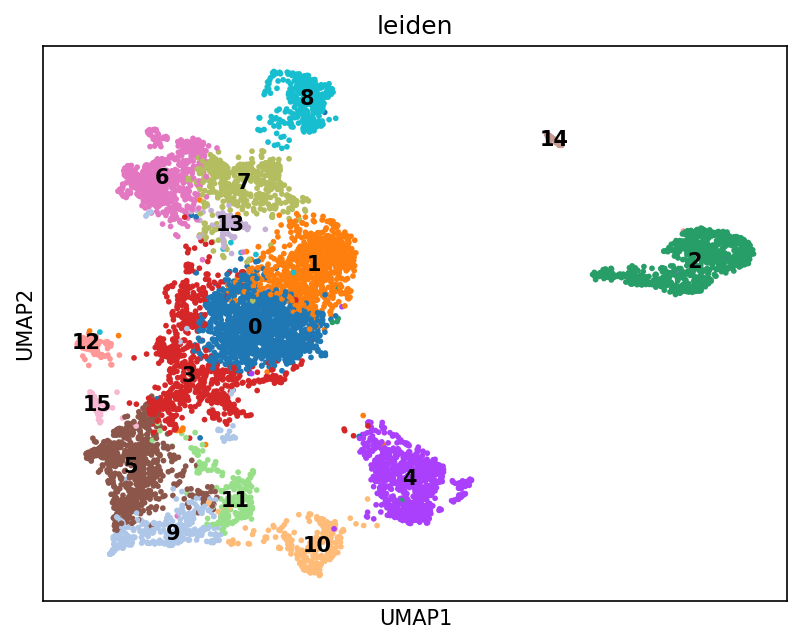

In [94]:
# run leiden clustering and plot the clustering result on the UMAP
sc.tl.leiden(adata_enr)
sc.pl.umap(adata_enr, color=["leiden"], size=30, legend_loc="on data")

In [95]:
# The following section requires gseapy, which is not installed by default.
!pip install gseapy

/Users/duo.peng/miniforge3/envs/grassp/lib/python3.12/site-packages/gseapy/enrichr.py:655: RuntimeWarning: divide by zero encountered in log
  "Combined Score": -1 * np.log(pvals) * oddr,
/Users/duo.peng/miniforge3/envs/grassp/lib/python3.12/site-packages/gseapy/enrichr.py:655: RuntimeWarning: divide by zero encountered in log
  "Combined Score": -1 * np.log(pvals) * oddr,


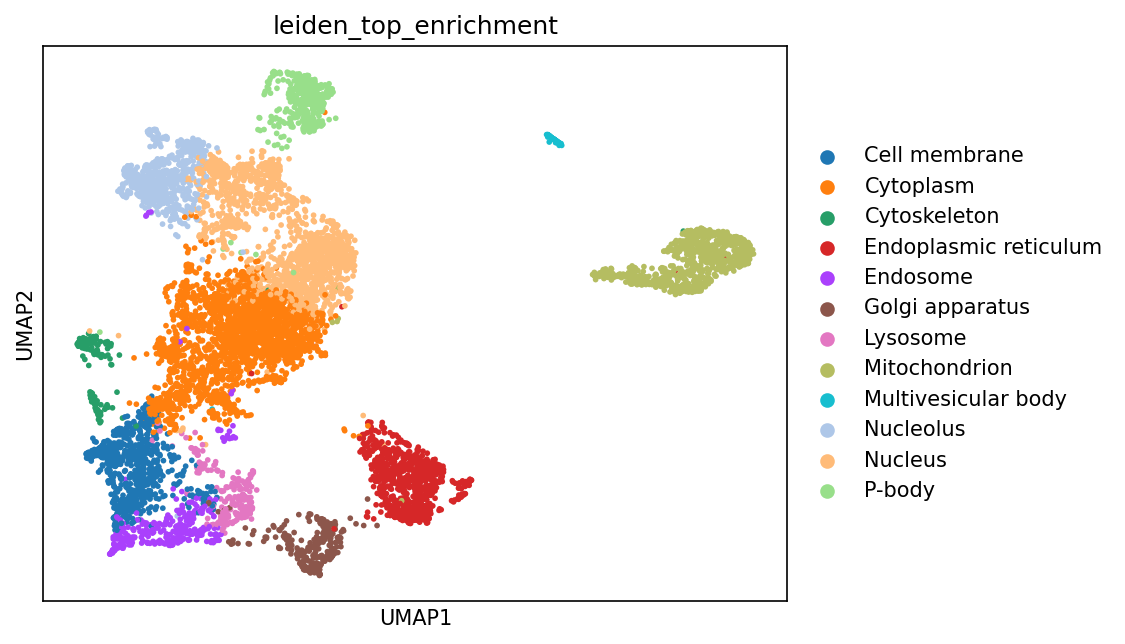

In [96]:
# These clusters can be annotated either manually or by using a set of markers.
# In this example, we use gseapy to run an Enrichr analysis for each protein cluster to identify the most enriched biological terms and pathways.
enrichment_results = gr.tl.calculate_cluster_enrichment(
    adata_enr,
    cluster_key="leiden",
    gene_name_key="Gene_name_canonical",
    obs_key_added="leiden_top_enrichment",
    enrichment_ranking_metric="Combined Score",
)

sc.pl.umap(adata_enr, color=["leiden_top_enrichment"], size=30)